## Movie Recommendation Systems

In the dynamic landscape of entertainment, the sheer volume of available movies can be overwhelming for audiences seeking their next cinematic experience. To navigate this vast array of options, a personalized movie recommendation system emerges as a beacon, guiding viewers to films that align with their unique preferences and tastes. 

Recommendation systems utilize advanced algorithms to analyze user preferences and historical viewing patterns to curate a tailored list of recommendations that resonate with the user's cinematic interests. They help improve the quality of search results and provides more relevant items to user saving their time and effort. 

There are three main types of recommendation systems:

* **Popularity-based Filtering:** This is the most basic type of filtering which recommends an item based on its popularity and/or genre. It recommends the same top items to users with similar demographic features. The underlying concept in this filtering method is that items enjoying higher popularity are more likely to be appreciated by the average audience. 

* **Content-based Filtering:** It recommends related items taking a specific item as a basis. It makes recommendations based on item metadata, like actors, directors, genres, description etc. The fundamental concept driving these systems is that if someone enjoyed a specific item, they are likely to appreciate another item that shares similarities with it.

* **Collaborative Filtering:** This system finds people who share interests in common and makes recommendations based on that finding. Unlike their content-based equivalents, collaborative filters do not require item metadata.

### Loading the Dataset: 

In [ ]:
import pandas as pd 
import numpy as np 
df1=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')

The first dataset contains the following features:-

* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.


The second dataset has the following features:-

* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
* id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average - average ratings the movie recieved.
* vote_count - the count of votes recieved.

In [ ]:
# joining the two datasets on the id column
df1.columns = ['id', 'title1', 'cast', 'crew']
df2 = df2.merge(df1, on='id')
df2.head()

### 1. Popularity-based Filtering:

Using the average ratings of the movie as the determining factor would not be fair since the number of votes is not consistent, hence, these ratings are not diverse. 

Therefore, we need a score metric that takes into account the average rating as well as the number of votes for each movie, to calculate its popularity.

The Weighted Rating here is calculated as done by IMDB:

**Weighted Rating** = (v/(v+m) * R) + (m/(v+m) * C)

where, 
* v = no. of votes for the movie
* m = minimum no. of votes required to be listed in the chart
* R = average rating of the movie
* C = mean of vote_average

We have, **v = vote_count** and **R = vote_average** in the dataset

In [ ]:
df2.info()

In [ ]:
C = df2['vote_average'].mean()
C

In [ ]:
#taking the 90th percentile as the minimum threshold of votes required
m = df2['vote_count'].quantile(0.9).round()
m

The movies that have more than 1838 votes (more than 90 percentile) qualify to be in the top chart. Filtering the dataset according to this:

In [ ]:
top_movies = df2.copy().loc[df2['vote_count'] >= m]
print(top_movies.shape)

Now we can calculate the Popularity Score for these top movies:

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    
    return (v/(v+m) * R) + (m/(m+v) * C)

top_movies['score'] = top_movies.apply(weighted_rating, axis=1)

In [ ]:
top_movies.info()

In [ ]:
top_movies = top_movies.sort_values('score', ascending=False)
top_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

This list provides the top rated movies in the dataset irrespective of their genres. We can also modify this model to get a list of the top rated movies in a particular genre.

This type of filtering provides a general chart of recommendations to all the users. They are not sensitive to the interests and tastes of a particular user.

### 2. Content-based Filtering

This approach recommends items based on user preferences. It matches the requirement, considering the past actions of the user, patterns detected, or any explicit feedback provided by the user, and accordingly, makes a recommendation.
For eg - 
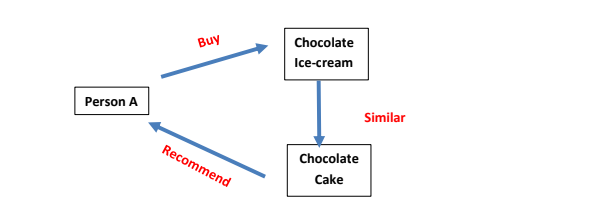

Here we will compute pairwise similarity scores for all movies based on their metadata such as overview, cast, crew, keywords, taglines, etc. and recommned movies on the basis of that similarity score. 

In [ ]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

Next, we'll write functions that will help us to extract the required information from each feature. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

In [ ]:
# Get the director's name from the crew feature.
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
# Returns the list top 3 elements 
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names

    return []

In [ ]:
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [ ]:
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(5)

Next we would convert the names and keyword instances into lowercase and strip all the spaces between them. 

In [ ]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)


Now we join all these columns together to create the metadata input for the vectorizer. This will give a matrix where each column represents a word in the overview vocabulary (all the words that appeared in at least one document) and each row represents a movie. This matrix is used to calculate the similarity between a pair of movies.

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

We use cosine similarity to calculate the similarity between two movies, since it is independent of magnitude and relatively faster to calculate.
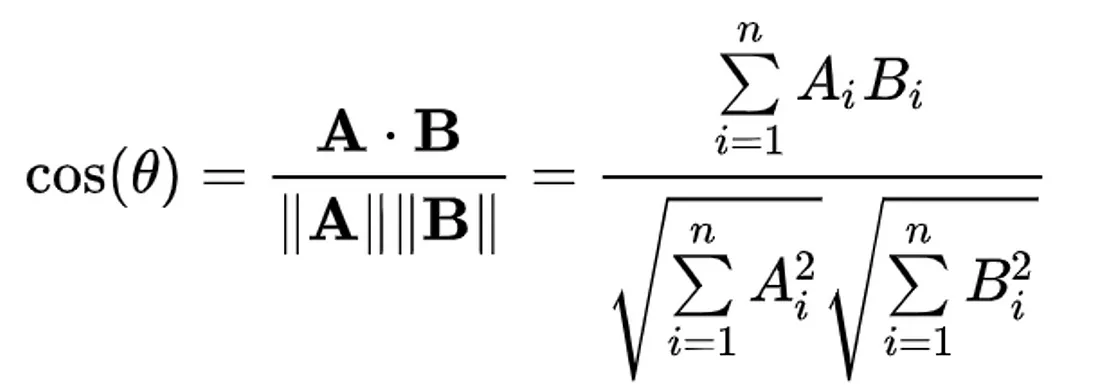

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(count_matrix, count_matrix)

We will now define a function that, given a movie title as input, returns a list of the ten most comparable films.

In [ ]:
#Constructing a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

Now, our recommendation model will follow the following steps:
* Take the title of the movie as input
* Calculate the cosine similarity scores of that particular movie with all the movies 
* Then return the top 10 movies with the highest similarity score

In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]

    # Calculate pairwise similarity scores with all movies
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the list according to the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top 10 movies leaving the first one (first one will be the movie itself)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    return df2['title'].iloc[movie_indices]

In [ ]:
get_recommendations('Avatar', cosine_sim)

### 3. Collaborative Filtering

The content-based filtering model has some limitations. It can only suggest items that are similar to a given item. They are not capable of capturing the personal tastes and biases of a user and provide recommendations across genres. Anyone querying our engine for movie recommendations will receive the same list, regardless of who he/she is. Hence, we use a collaborative filtering model.

This approach uses similarities between users and items simultaneously, to provide recommendations. It is the idea of recommending an item or making a prediction, depending on other like-minded individuals. 
For eg-
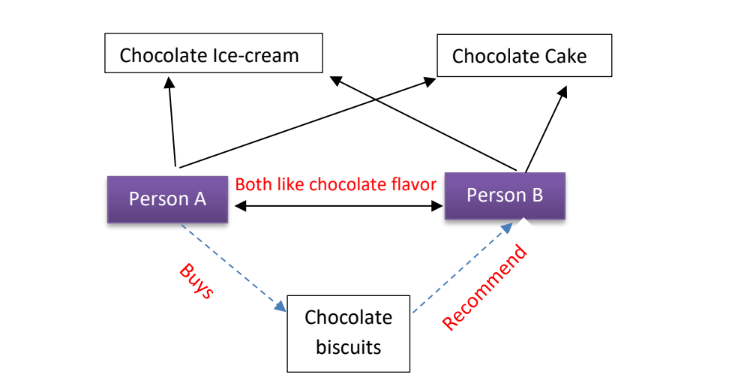

We use the **Singular Value Decomposition (SVD)** algorithm to capture the similarity between the users and items and generate the recommendations. 

SVD is a matrix factorisation technique, which reduces the number of features of a dataset by reducing the space dimension from N-dimension to K-dimension (where K<N). 
* It uses a matrix structure where each row represents a user, and each column represents an item. 
* The elements of this matrix are the ratings that are given to items by users.
* The factorisation of this matrix is done by the singular value decomposition.
* The SVD decreases the dimensions of the matrix A by extracting its latent factors, which are the characteristics of the items.
* It maps each user and each item which facilitates a clear representation of relationships between users and items.


In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
reader = Reader()
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
ratings.head()

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
from surprise.model_selection import KFold

kf = KFold(n_splits=5)
kf.split(data)

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

We get a mean Root Mean Sqaure Error of 0.89 approx which is good enough for our case. Let us now train on our dataset and arrive at predictions.

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Let's use the model to predict what rating would user '1' give to movie '1172'

In [ ]:
svd.predict(1, 1172, 3)

The model predicts that user will rate this movie as ~3.6.
Using these predicted ratings, we can find out what movies will the user like and recommend it to the user.

### 4. Hybrid Recommender

This model will bring together these techniques used to build the content-based and collaborative model, to produce the recommendations.

* It'll take the UserID and title of a movie as an input
* And return similar movies sorted according to the expected ratings by that user

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
links_small = pd.read_csv('/kaggle/input/the-movies-dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
md = pd. read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
md = md.drop([19730, 29503, 35587])
md['id'] = md['id'].astype('int')
smd = md[md['id'].isin(links_small)]

In [ ]:
id_map = pd.read_csv('/kaggle/input/the-movies-dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
id_map.head()

In [ ]:
indices_map = id_map.set_index('id')

In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(20, 'The Postman')

In [ ]:
hybrid(1, 'The Postman')

We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.

### References:
* https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system/notebook#Collaborative-Filtering
* https://www.kaggle.com/code/rounakbanik/movie-recommender-systems/notebook
* https://jusst.org/wp-content/uploads/2020/12/Comparative-Study-of-Machine-Learning-Algorithms-for-Recommendation.pdf
* https://www.mygreatlearning.com/blog/matrix-factorization-explained/
* https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/#:~:text=SVD%20is%20a%20matrix%20factorisation,(where%20K%3CN).